In [155]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

In [156]:
library(svglite)

In [157]:
library(ComplexUpset)

In [158]:
library(ggrepel)

In [159]:
library(ComplexHeatmap)

In [160]:
source('../src/common_functions.R')

In [161]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

# Create DE df

# GOSEQ

In [162]:
df_transport_classes = read_csv(file.path('DE_results', 'transport_classes.csv'), name_repair = 'universal' )

New names:
• `Original Name` -> `Original.Name`
• `Compound Category` -> `Compound.Category`
• `Substrate(s)` -> `Substrate.s.`
Rows: 48 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Original.Name, Type, Compound.Category, Substrate.s., Direction, Notes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [163]:
df_all = read_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 53457 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (22): contrast, protein_id, Assay, contrast1, Name, gene, locus_tag, old...
dbl  (7): logFC, AveExpr, pvalue, padj, start, end, gene_length
lgl  (5): Note, exception, down, up, is_de

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [164]:
goseq_res = read_csv(file.path('DE_results', 'MED4_GOSEQ_results.csv'))

Rows: 11952 Columns: 17
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): category, type, enrich, contrast, organism, main, sub, module, Cat...
dbl  (5): over_represented_pvalue, padj, under_represented_pvalue, numDEInCa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [165]:
goseq_res = goseq_res %>%
    mutate(Category = factor(Category, levels=category.order))


In [166]:
head(goseq_res)

category,over_represented_pvalue,padj,under_represented_pvalue,numDEInCat,numInCat,type,enrich,contrast,organism,main,sub,module,Category,PATH,pathway,path
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
09122,3.495425e-05,0.0008738563,0.9999942,12,74,down,sub,C2vsC1_prot,MED4,09120 Genetic Information Processing,09122 Translation,Translation,Genetic Info,09122 Translation,Translation,NA
09182,1.089670e-02,0.1362087235,0.9955543,20,275,down,sub,C2vsC1_prot,MED4,09180 Brite Hierarchies,09182 Protein families: genetic information processing,Protein families: genetic information processing,Genetic Info,09182 Protein families: genetic information processing,Protein families: genetic information processing,NA
09109,3.230502e-01,1.0000000000,0.8959224,2,25,down,sub,C2vsC1_prot,MED4,09100 Metabolism,09109 Metabolism of terpenoids and polyketides,terpenoids and polyketides,Metabolism,09109 Metabolism of terpenoids and polyketides,Metabolism of terpenoids and polyketides,NA
09132,3.463884e-01,1.0000000000,0.8824203,2,27,down,sub,C2vsC1_prot,MED4,09130 Environmental Information Processing,09132 Signal transduction,Signal transduction,Env. Info/Cellular Process,09132 Signal transduction,Signal transduction,NA
09192,3.619801e-01,1.0000000000,0.9327281,1,10,down,sub,C2vsC1_prot,MED4,09190 Not Included in Pathway or Brite,09192 Unclassified: genetic information processing,Unclassified: genetic information processing,Genetic Info,09192 Unclassified: genetic information processing,Unclassified: genetic information processing,NA
09181,4.331008e-01,1.0000000000,0.7174545,8,156,down,sub,C2vsC1_prot,MED4,09180 Brite Hierarchies,09181 Protein families: metabolism,Protein families:,Metabolism,09181 Protein families: metabolism,Protein families: metabolism,NA


In [167]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C")~ "Coculture", 
        str_detect(contrast, "P3|P5|LATEvsP")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

,Assay,Group
,<fct>,<fct>
C1vsP1_rna,rna,Coculture
C2vsC1_rna,rna,Coculture
C3vsC1_rna,rna,Coculture
C3vsC2_rna,rna,Coculture
C4vsC1_rna,rna,Coculture
C4vsC3_rna,rna,Coculture
C5vsC1_rna,rna,Coculture
C5vsC3_rna,rna,Coculture
C5vsC4_rna,rna,Coculture


In [168]:
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 300)

In [169]:
goseq_pal_fc_fun = colorRamp2(c(-5,-2,-1, 0, 1,2, 5), rev(RColorBrewer::brewer.pal(7, "BrBG")))
pfcgoseq = goseq_pal_fc_fun(seq(-10, 10, length.out = 20))
#pfcgoseq = goseq_pal_up_fun(c(-5, -2, 0, 2, 5))
#show_col(pfcgoseq)

In [170]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [171]:
coclture_assays = goseq_meta %>% filter(Group == "Coculture") %>% row.names()

In [172]:
dput(sort(unique(goseq_res$contrast)))
contrast_list = c( "LATEvsC1_prot", #"LATEvsC2_prot",  
"P2vsP1_prot",  #"LATEvsP1_prot", 
"LATEvsP2_prot", #"LATEvsP1_rna", 
                  "LATEvsP2_rna", "LATEvsC1_rna", "LATEvsP1_prot",
#"LATEvsC2_rna",  
                  "P2vsP1_rna" )

contrast_list_survival = c( 
    "LATEvsC1_prot", #"LATEvsC2_prot",  
    "LATEvsC1_rna", 
"P2vsP1_prot",  #"LATEvsP1_prot", 
                  "P2vsP1_rna" 
 #"LATEvsP1_rna", 
                  #"LATEvsP2_rna", 
#"LATEvsC2_rna",  
)
contrast_list_death = c( 
     
"P2vsP1_prot",  "LATEvsP1_prot", 
                  "P2vsP1_rna" ,
"LATEvsP2_prot"
)

contrast_list_coculture = c( 
    "C2vsC1_prot" , 
    "C2vsC1_rna" , 
    "C3vsC2_prot", 
    "C3vsC2_rna" , 
    "C4vsC3_prot", 
    "C4vsC3_rna" , 
    "C5vsC4_prot", 
    "C5vsC4_rna" 
    )

comparison_order_survival = c("Death\nvs growth", "Survival\nvs growth")
comparison_order_death = c("Death\nvs growth", "Decompsing\nvs death", "Decompsing\nvs growth" )

c("C1vsP1_rna", "C2vsC1_prot", "C2vsC1_rna", "C3vsC1_prot", "C3vsC1_rna", 
"C3vsC2_prot", "C3vsC2_rna", "C4vsC1_prot", "C4vsC1_rna", "C4vsC2_prot", 
"C4vsC3_prot", "C4vsC3_rna", "C5vsC1_prot", "C5vsC1_rna", "C5vsC2_prot", 
"C5vsC3_prot", "C5vsC3_rna", "C5vsC4_prot", "C5vsC4_rna", "LATEvsC1_prot", 
"LATEvsC1_rna", "LATEvsC2_prot", "LATEvsC2_rna", "LATEvsC3_prot", 
"LATEvsC3_rna", "LATEvsP1_prot", "LATEvsP1_rna", "LATEvsP2_prot", 
"LATEvsP2_rna", "P2vsP1_prot", "P2vsP1_rna", "P3vsP1_prot", "P5vsP1_prot"
)


In [173]:
contrast_list_pro_continues_minus_C3_c1 = c(
    "P2vsP1_prot", 
    "P3vsP1_prot", 
    "P5vsP1_prot",
    "P2vsP1_rna", 

    "C2vsC1_prot", 
   # "C3vsC1_prot", 
    "C4vsC1_prot", 
    "C5vsC1_prot",
	
    "C2vsC1_rna", 
    "C3vsC1_rna", 
    "C4vsC1_rna", 
    "C5vsC1_rna", 
	
    "C3vsC2_prot", 
    "C4vsC3_prot", 
    "C5vsC4_prot", 
	
    "C3vsC2_rna", 
    "C4vsC3_rna", 
    "C5vsC4_rna"
	
)


In [174]:
-log10(0.05)

[1] 1.30103

In [175]:
names(df_all)

[1] "contrast"           "protein_id"         "logFC"             
 [4] "AveExpr"            "pvalue"             "padj"              
 [7] "Assay"              "contrast1"          "Name"              
[10] "gene"               "locus_tag"          "old_locus_tag"     
[13] "source"             "start"              "end"               
[16] "strand"             "Note"               "exception"         
[19] "inference"          "product"            "gene_length"       
[22] "path_id"            "main"               "sub"               
[25] "path"               "ecpath"             "Category"          
[28] "Membrane.transport" "kegg_gene1"         "kegg_gene2"        
[31] "gene_id"            "down"               "up"                
[34] "is_de"

In [176]:
genome = 'MED4'

In [177]:
deg = df_all %>% filter(padj < 0.05) %>% distinct(gene_id)
df_all %>% 
    filter(Membrane.transport %in% 'Membrane transport') %>%
    filter(gene_id %in% deg$gene_id) %>% 
    distinct(gene_id, .keep_all = TRUE) %>%
    count(path)


path,n
<chr>,<int>
00480 Glutathione metabolism [PATH:ko00480];00980 Metabolism of xenobiotics by cytochrome P450 [PATH:ko00980];00982 Drug metabolism - cytochrome P450 [PATH:ko00982];00983 Drug metabolism - other enzymes [PATH:ko00983];02000 Transporters [BR:ko02000],3
00910 Nitrogen metabolism [PATH:ko00910];02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],3
01011 Peptidoglycan biosynthesis and degradation proteins [BR:ko01011];02000 Transporters [BR:ko02000],1
01504 Antimicrobial resistance genes [BR:ko01504];02000 Transporters [BR:ko02000],1
02000 Transporters [BR:ko02000],27
02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],25
02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010];02020 Two-component system [PATH:ko02020],4
02000 Transporters [BR:ko02000];02020 Two-component system [PATH:ko02020];02026 Biofilm formation - Escherichia coli [PATH:ko02026],2
02000 Transporters [BR:ko02000];02024 Quorum sensing [PATH:ko02024],4


In [178]:
transport_genes = df_all %>% 
    filter(Membrane.transport %in% 'Membrane transport') %>%
    #filter(padj < 0.05) %>% 
    distinct(gene_id) 
transport_de_genes = df_all %>% 
    filter(Membrane.transport %in% 'Membrane transport') %>%
    filter(padj < 0.05) %>% 
    distinct(gene_id) 
df_transport = df_all %>% 
    #filter(Membrane.transport %in% 'Membrane transport') %>%
    filter(gene_id %in% transport_genes$gene_id) %>% 
    distinct(gene_id, .keep_all = TRUE) %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; ([^\\[,]+)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(system, "system"),str_remove(system, "system.*"), system)) %>%
    mutate(system = if_else(str_detect(system, "subunit"),str_remove(system, "subunit.*"), system)) %>%
    mutate(system = if_else(str_detect(system, " protein"),str_remove(system, " protein.*"), system)) %>% # add the space to avoid preprotein
    #extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; ([^\\[]+)", remove = FALSE) %>%
    mutate(system=str_trim(system)) #%>%
    #count(system) %>% write_csv('tmp.csv')


In [ ]:
transport_genes %>%count(system) %>% write_csv('tmp.csv')

In [179]:
names(df_transport)
names(df_transport_classes)

[1] "contrast"           "protein_id"         "logFC"             
 [4] "AveExpr"            "pvalue"             "padj"              
 [7] "Assay"              "contrast1"          "Name"              
[10] "gene"               "locus_tag"          "old_locus_tag"     
[13] "source"             "start"              "end"               
[16] "strand"             "Note"               "exception"         
[19] "inference"          "product"            "gene_length"       
[22] "path_id"            "main"               "sub"               
[25] "path"               "ecpath"             "system"            
[28] "Category"           "Membrane.transport" "kegg_gene1"        
[31] "kegg_gene2"         "gene_id"            "down"              
[34] "up"                 "is_de"

[1] "Original.Name"     "Type"              "Compound.Category"
[4] "Substrate.s."      "Direction"         "Notes"

In [180]:

gene_meta = df_transport %>% 
    distinct(gene_id, .keep_all = TRUE) %>% 
    mutate(protein.export = if_else(str_detect(path, regex('Protein export', ignore_case=TRUE)), 'Protein export', '')) %>%
    mutate(secretion.system = if_else(str_detect(path, regex('Secretion system', ignore_case=TRUE)), 'Secretion system', '')) %>%
    left_join((df_transport_classes %>% rename(system=Original.Name)), by='system') %>%
    mutate(Direction = if_else(Direction == 'bidirectional', 'other', Direction)) %>%
    mutate(Compound.Category = if_else(protein.export == 'Protein export', 'Protein', Compound.Category)) %>%
    mutate(Direction = if_else(protein.export == 'Protein export', 'export', Direction)) %>%
    distinct(gene_id, gene, system, Compound.Category,Direction, Substrate.s.) %>%
    column_to_rownames('gene_id')
head(gene_meta)


#    distinct(gene_id, gene, system, sub,path,ecpath, protein.export, secretion.system) %>%
    #count(Compound.Category,Direction,  is_de) %>% pivot_wider(names_from = 'is_de', values_from = 'n', values_fill = 0) 

,gene,system,Compound.Category,Direction,Substrate.s.
,<chr>,<chr>,<chr>,<chr>,<chr>
TX50_RS01980,NA,nitrate/nitrite transport,inorganic N,uptake,Nitrate (NO₃⁻); Nitrite (NO₂⁻)
TX50_RS05175,urtD,urea transport,Urea,uptake,Urea
TX50_RS05180,urtE,urea transport,Urea,uptake,Urea
TX50_RS05170,urtC,urea transport,Urea,uptake,Urea
TX50_RS01975,ntrB,nitrate/nitrite transport,inorganic N,uptake,Nitrate (NO₃⁻); Nitrite (NO₂⁻)
TX50_RS01970,NA,nitrate/nitrite transport,inorganic N,uptake,Nitrate (NO₃⁻); Nitrite (NO₂⁻)


## Transporters

In [181]:
module_name = 'Membrane transport'
module_title = paste0(genome, ' ',module_name)

In [182]:

degenes = df_all %>% 
    filter(Membrane.transport %in% 'Membrane transport') %>%
    filter(padj < 0.05) %>% 
    filter(contrast1 %in% contrast_list_survival) %>%
    distinct(gene_id) 

degenes

gene_id
<chr>
TX50_RS01365
TX50_RS08715
TX50_RS07180
TX50_RS01980
TX50_RS05640
TX50_RS05170
TX50_RS01970
TX50_RS01975
TX50_RS04955


In [183]:
df_all %>% filter(gene_id %in% df_transport$gene_id) %>% 
    filter(contrast1 %in% contrast_list_survival) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=contrast_list)) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 

,TX50_RS01980,TX50_RS05175,TX50_RS05180,TX50_RS05170,TX50_RS01975,TX50_RS01970,TX50_RS07765,TX50_RS03200,TX50_RS05160,TX50_RS03760,⋯,TX50_RS05205,TX50_RS05535,TX50_RS06335,TX50_RS06530,TX50_RS07105,TX50_RS07730,TX50_RS07840,TX50_RS07845,TX50_RS08725,TX50_RS09050
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LATEvsC1_prot,*,*,*,*,*,*,*,,*,,⋯,,,,,,,,,,
P2vsP1_prot,*,,,,,*,,,*,*,⋯,,,,,,,,,,
LATEvsC1_rna,,,,,,,,*,,,⋯,,,,,,,,,,
P2vsP1_rna,*,*,*,,*,*,*,*,*,*,⋯,,,,*,,,*,,,*


In [194]:
gene_stars_survival = df_all %>% filter(gene_id %in% df_transport$gene_id) %>% 
    filter(contrast1 %in% contrast_list_survival) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=contrast_list_survival)) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [195]:
contrast_map_to_label_pro_survival_death[contrast_list_survival]

LATEvsC1_prot          LATEvsC1_rna           P2vsP1_prot 
"Survival\nvs growth" "Survival\nvs growth"    "Death\nvs growth" 
           P2vsP1_rna 
   "Death\nvs growth"

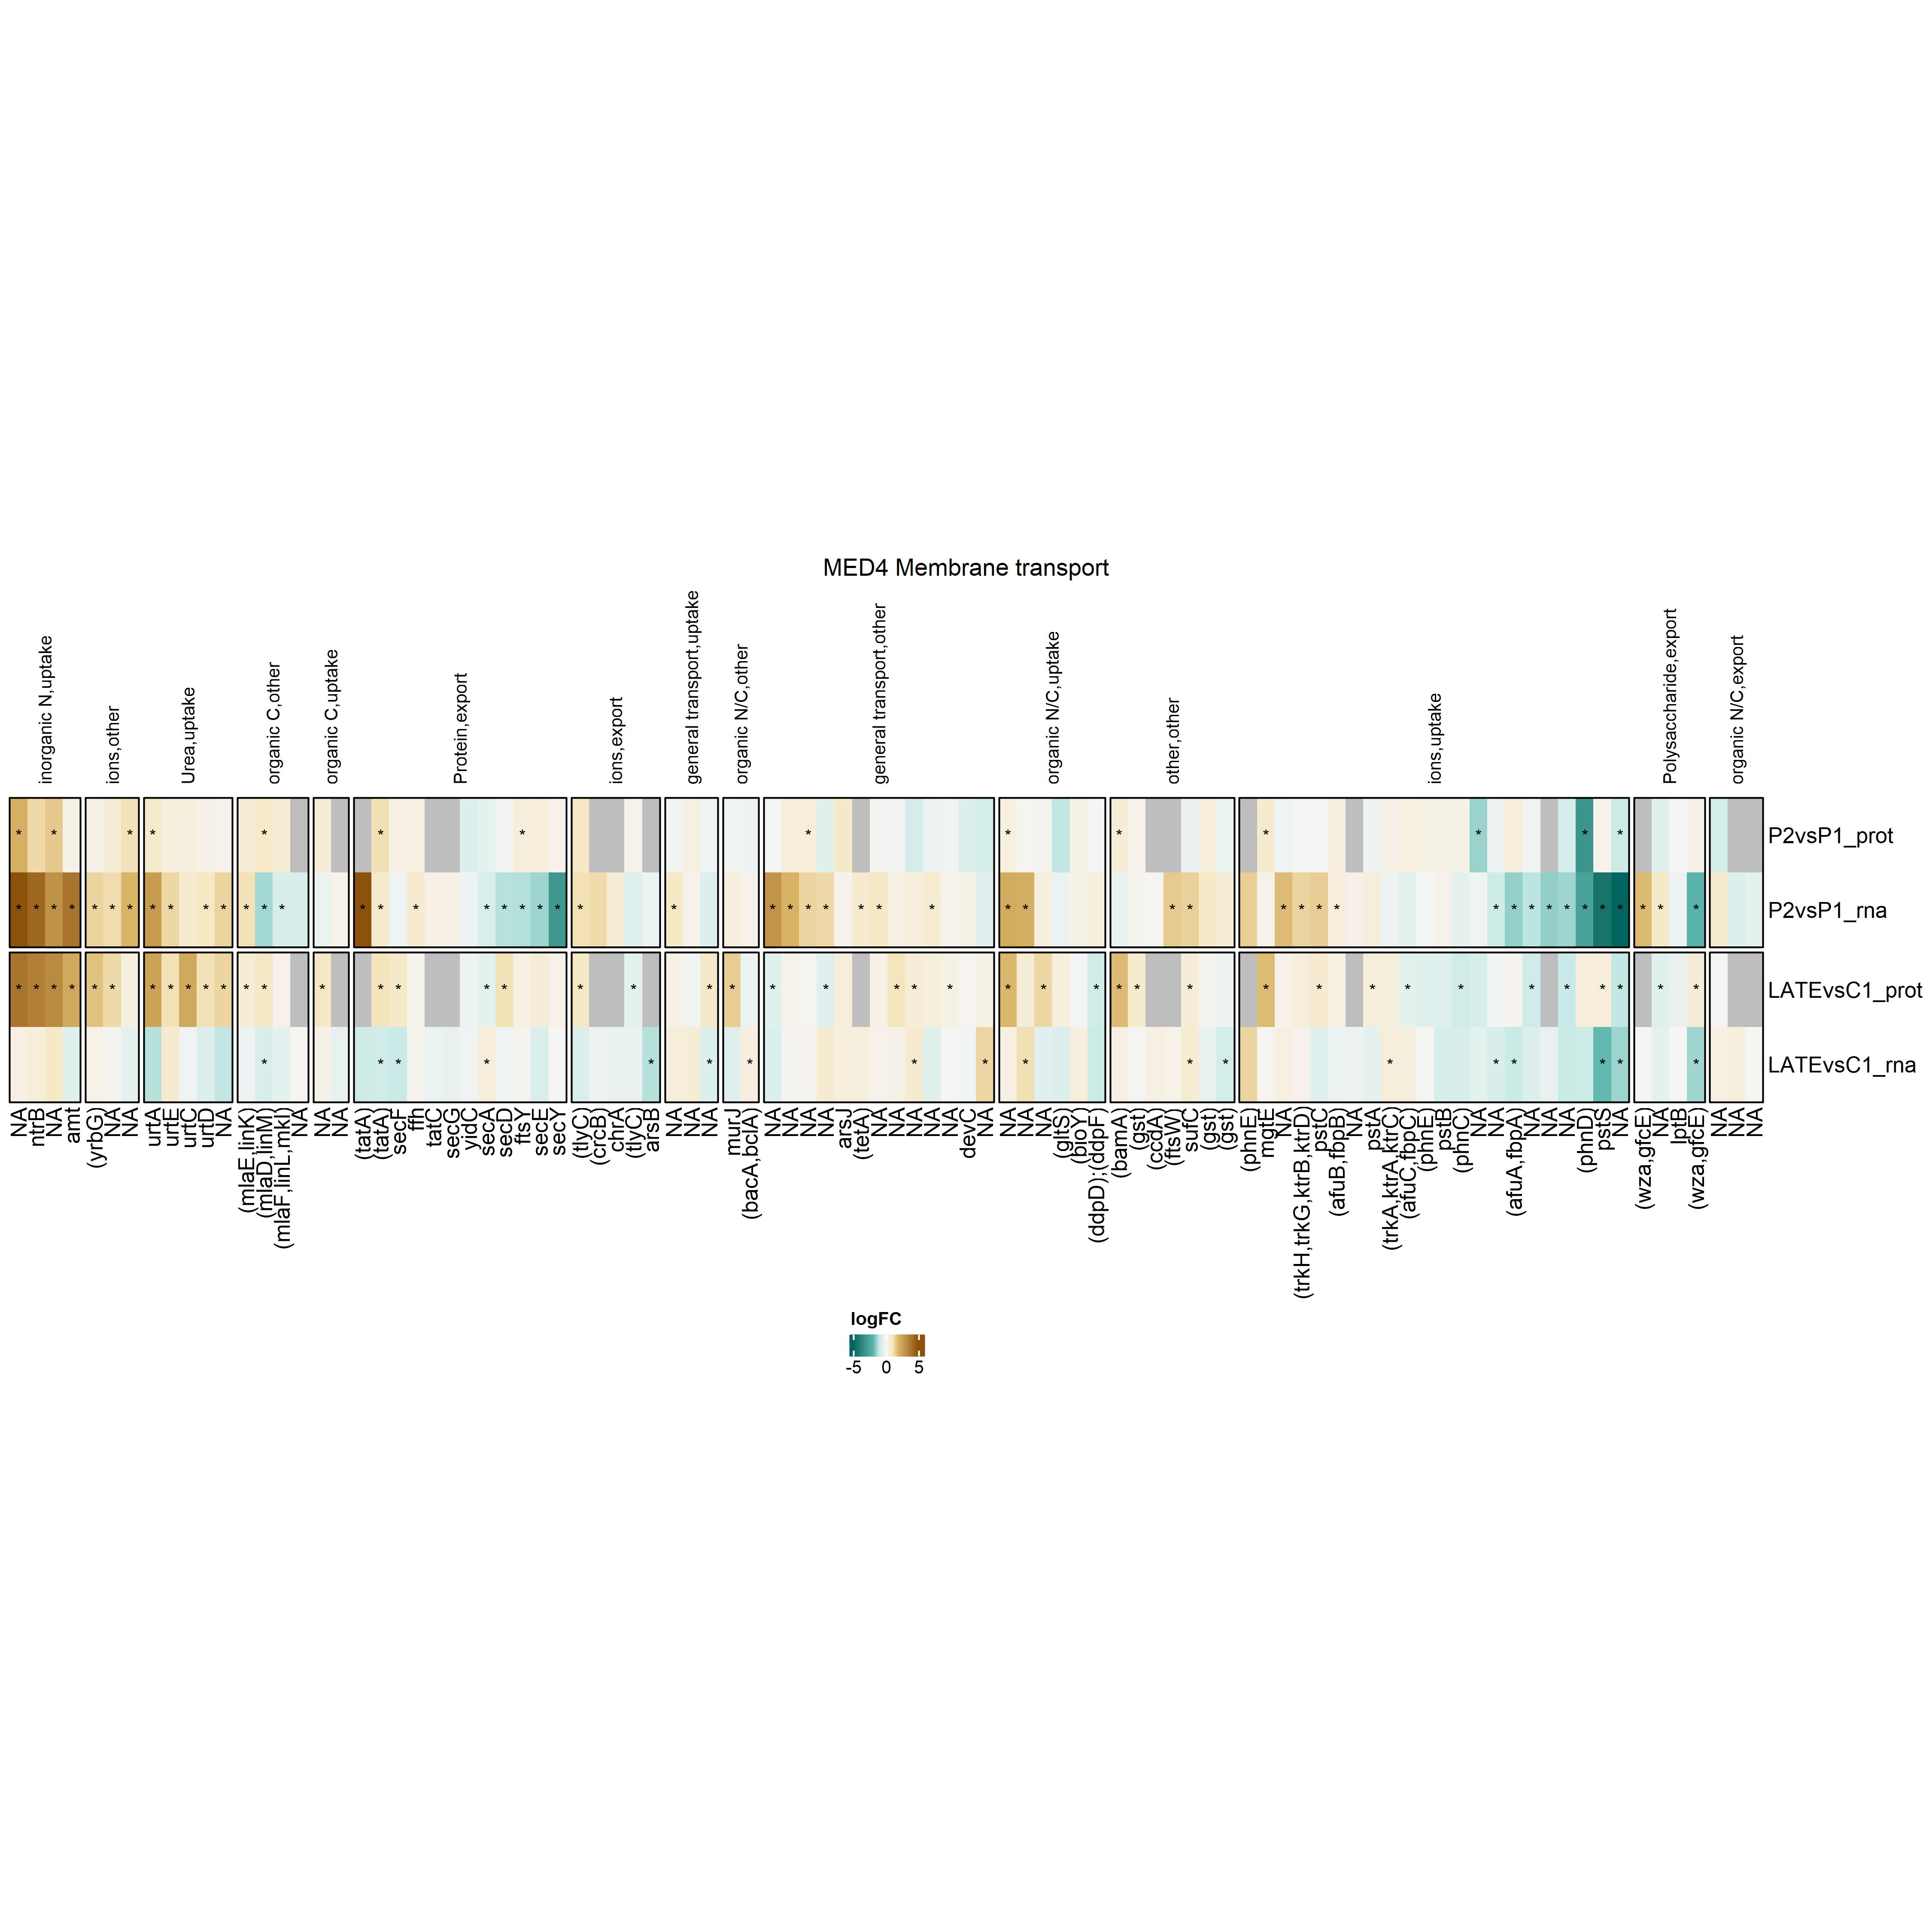

In [196]:

gene_mat = df_all %>% filter(gene_id %in% df_transport$gene_id) %>% 
    filter(contrast1 %in% contrast_list_survival) %>%
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=contrast_list_survival)) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     #row_order = rownames(goseq_meta),
     row_split = contrast_map_to_label_pro_survival_death[contrast_list_survival],
    
#     #row_title_gp = gpar(col = group_pal),
#     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     #column_title=NULL,
    column_split = gene_meta %>% select(Compound.Category, Direction), # Substrate.s.),
    column_title_gp = gpar(fontsize = 10),    
    column_title_rot = 90,
    column_labels=gene_meta$gene,
#     top_annotation = HeatmapAnnotation(
#         Pathway=gene_meta$system, 
#         #show_legend =FALSE,
#         #col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
#         #show_legend=FALSE,
#     ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars_survival[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat  #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [187]:
gene_stars_continues = df_all %>% filter(gene_id %in% df_transport$gene_id) %>% 
    filter(contrast1 %in% contrast_list_pro_continues) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=contrast_list_pro_continues)) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


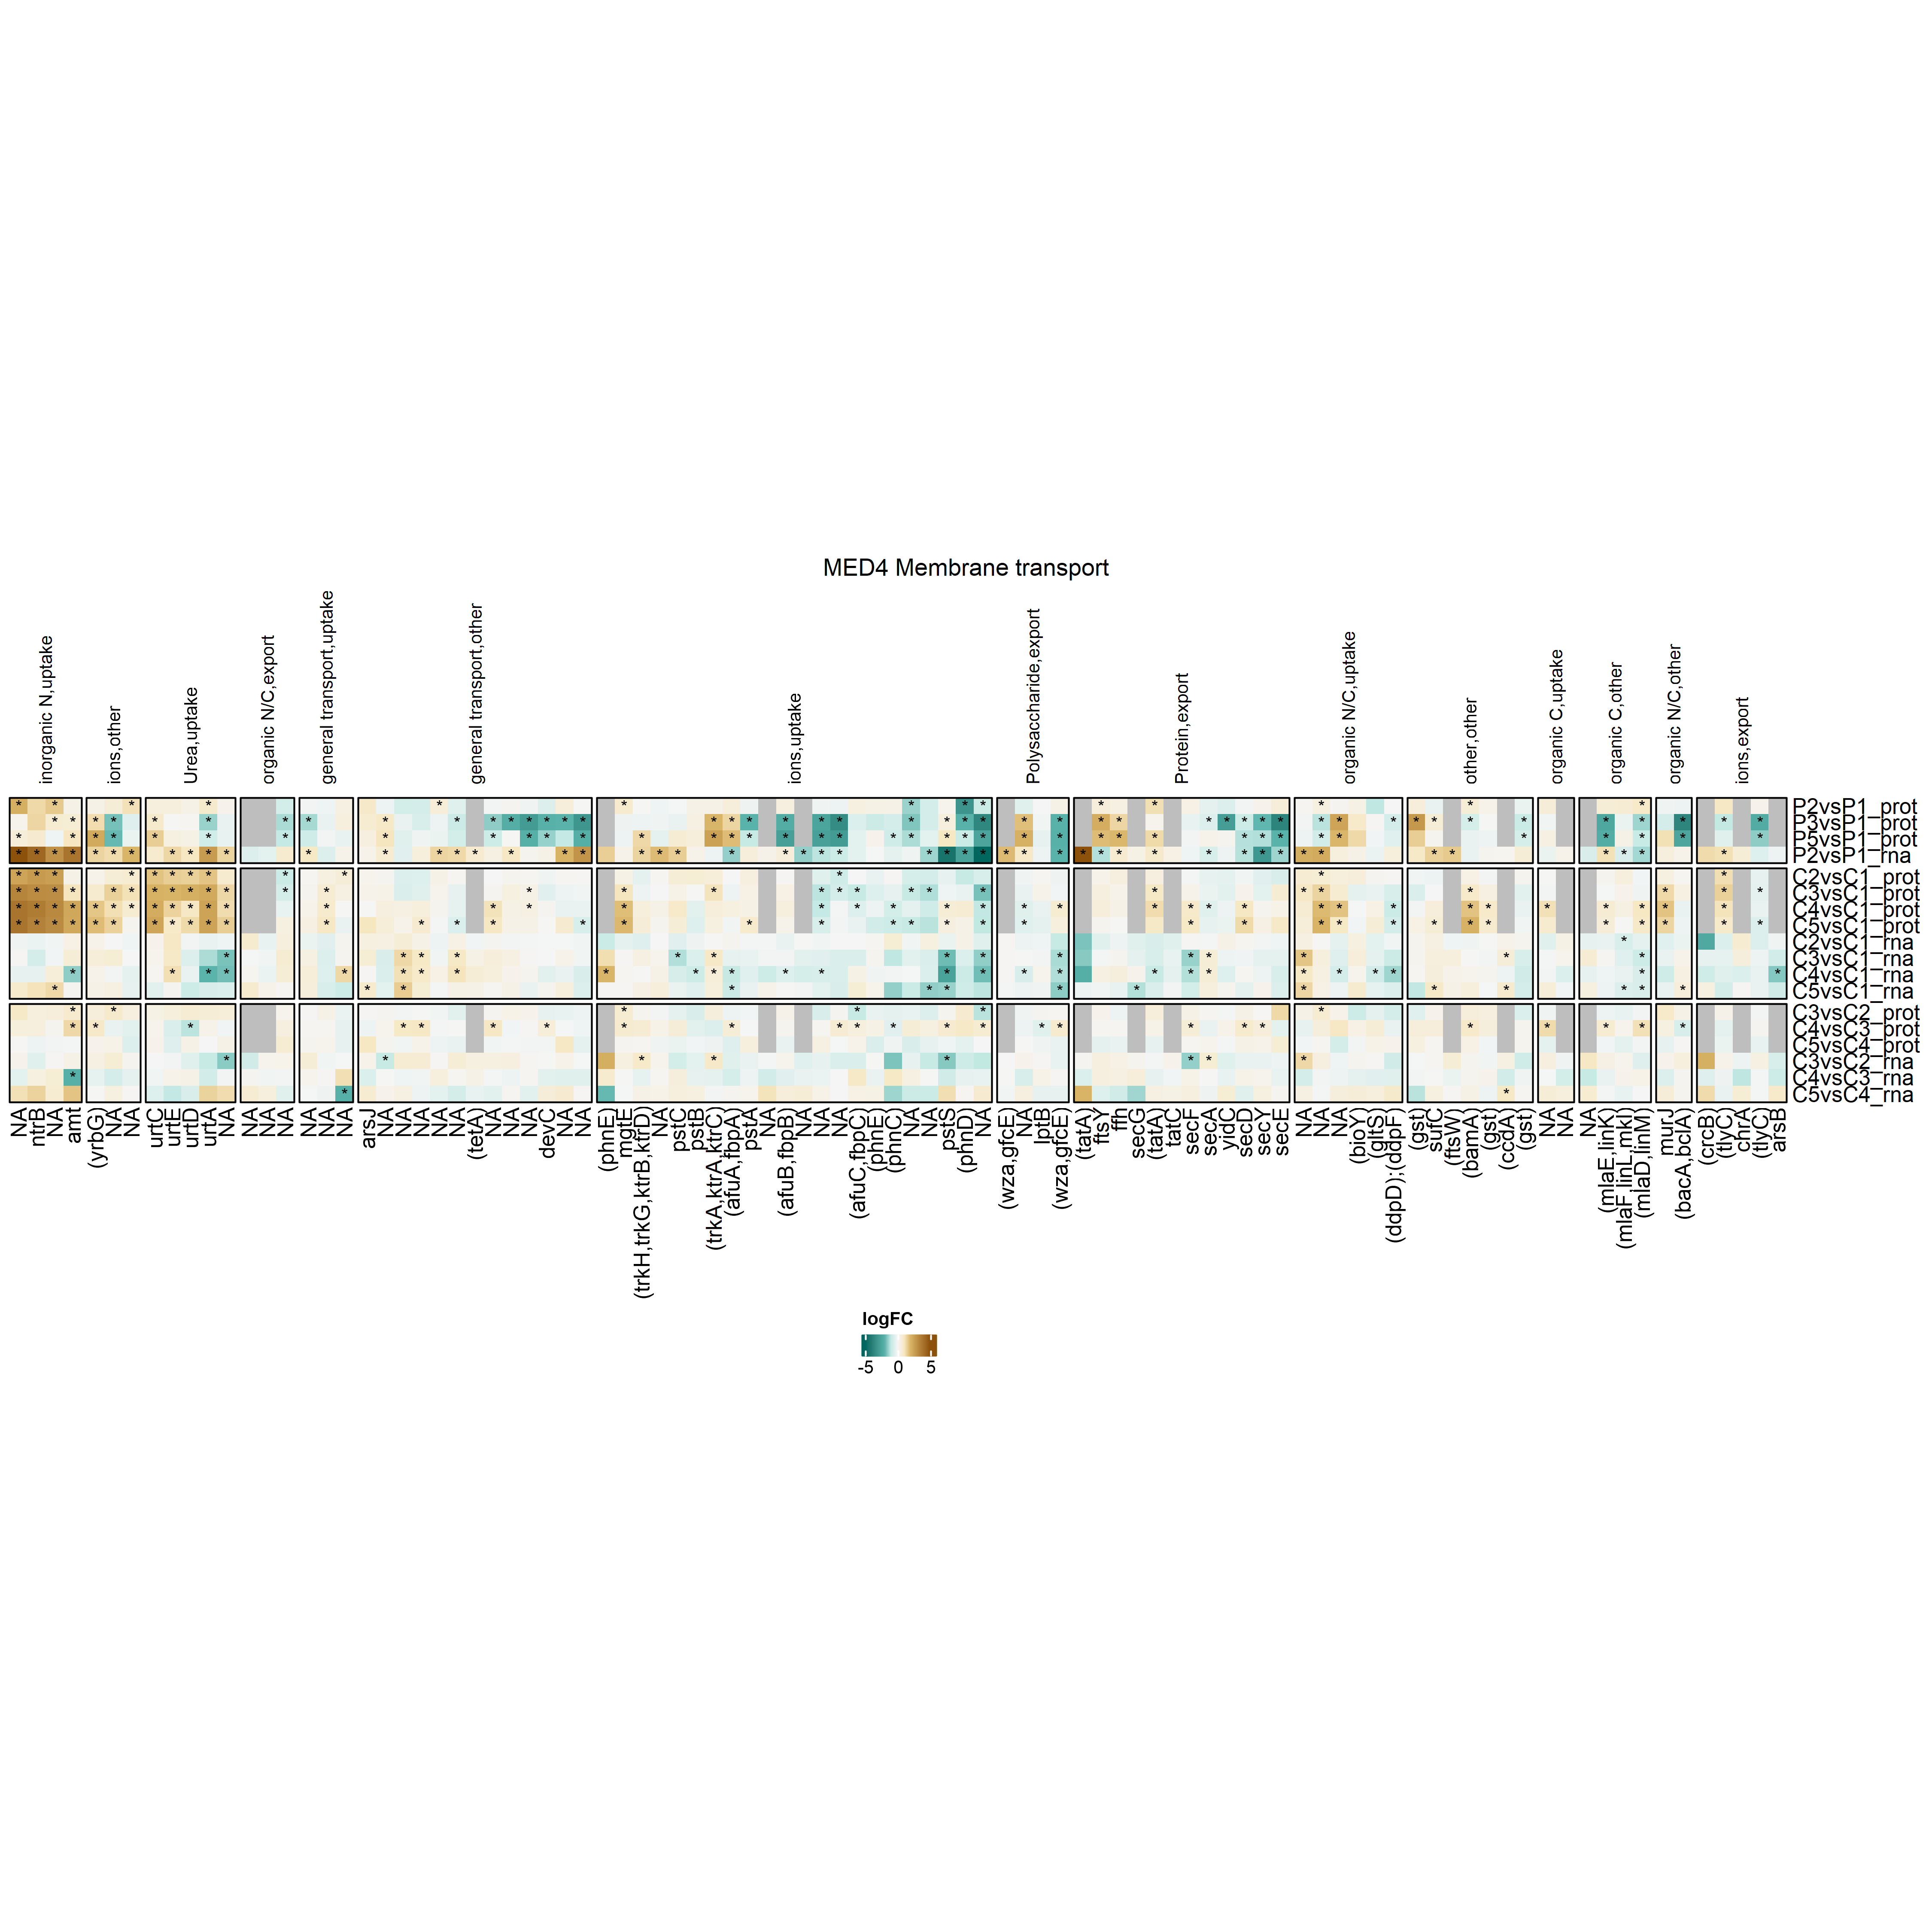

In [188]:

gene_mat = df_all %>% filter(gene_id %in% df_transport$gene_id) %>% 
    filter(contrast1 %in% contrast_list_pro_continues) %>%
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=contrast_list_pro_continues)) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     #row_order = rownames(goseq_meta),
     row_split = contrast_map_to_label_pro_continues[contrast_list_pro_continues],
    
#     #row_title_gp = gpar(col = group_pal),
#     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     #column_title=NULL,
    column_split = gene_meta %>% select(Compound.Category, Direction), #, Substrate.s.),
    column_title_gp = gpar(fontsize = 10),    
    column_title_rot = 90,
    column_labels=gene_meta$gene,
#     top_annotation = HeatmapAnnotation(
#         Pathway=gene_meta$system, 
#         #show_legend =FALSE,
#         #col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
#         #show_legend=FALSE,
#     ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars_continues[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat  #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [189]:
paste0(unique(gene_meta$system), collapse = ' , ')

[1] "nitrate/nitrite transport , urea transport , magnesium and cobalt exporter , manganese transport , voltage-gated potassium channel , viologen exporter family transport , peptide/nickel transport , energy-coupling factor transport , phosphate transport , phospholipid/cholesterol/gamma-HCH transport , signal recognition particle , sulfate permease , preprotein translocase , trk/ktr , ATP-binding cassette , chloride channel , phosphonate transport , magnesium transporter , outer membrane , YidC/Oxa1 family membrane , ammonium transporter , ABC-2 type transport , iron complex transport , biotin transport , sec-independent , putative peptidoglycan lipid II flippase , fused signal recognition particle receptor , Fe-S cluster assembly ATP-binding , polysaccharide biosynthesis/export , lipopolysaccharide export , cation:H+ antiporter , vitamin B12/bleomycin/antimicrobial peptide transport , glutathione S-transferase , heterocyst specific transport , glutamate:Na+ symporter , MFS transporter , manganese/iron transport , putative ABC transport , iron(III) transport , malate permease and related , chromate transporter , arsenite transporter , MtN3 and saliva related transmembrane , glycoside/pentoside/hexuronide:cation symporter , cell division , cytochrome c-type biogenesis , fluoride exporter"

In [190]:
sessionInfo()

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 26100)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       ggrepel_0.9.1              
 [3] ComplexUpset_1.3.3          svglite_2.1.3              
 [5] circlize_0.4.15             corrplot_0.92              
 [7] pheatmap_1.0.12             lubridate_1.9.2            
 [9] forcats_1.0.0               stringr_1.5.0              
[11] dplyr_1.1.0                 purrr_1.0.1                
[13] readr_2.1.4                 tidyr_1.3.0                
[15] tibble_3.1.8                tidyverse_2.0.0            
[17] readxl_1.4.2                gos

In [198]:
gene_meta

,gene,system,Compound.Category,Direction,Substrate.s.
,<chr>,<chr>,<chr>,<chr>,<chr>
TX50_RS01980,NA,nitrate/nitrite transport,inorganic N,uptake,Nitrate (NO₃⁻); Nitrite (NO₂⁻)
TX50_RS05175,urtD,urea transport,Urea,uptake,Urea
TX50_RS05180,urtE,urea transport,Urea,uptake,Urea
TX50_RS05170,urtC,urea transport,Urea,uptake,Urea
TX50_RS01975,ntrB,nitrate/nitrite transport,inorganic N,uptake,Nitrate (NO₃⁻); Nitrite (NO₂⁻)
TX50_RS01970,NA,nitrate/nitrite transport,inorganic N,uptake,Nitrate (NO₃⁻); Nitrite (NO₂⁻)
TX50_RS07765,(tlyC),magnesium and cobalt exporter,ions,export,Magnesium (Mg²⁺); Cobalt (Co²⁺)
TX50_RS03200,NA,manganese transport,ions,uptake,Manganese (Mn²⁺)
TX50_RS05160,urtA,urea transport,Urea,uptake,Urea


In [191]:
help(str_detect)

str_detect {stringr},R Documentation
string,"Input vector. Either a character vector, or something coercible to one."
pattern,"Pattern to look for. The default interpretation is a regular expression, as described in vignette(""regular-expressions""). Use regex() for finer control of the matching behaviour. Match a fixed string (i.e. by comparing only bytes), using fixed(). This is fast, but approximate. Generally, for matching human text, you'll want coll() which respects character matching rules for the specified locale. Match character, word, line and sentence boundaries with boundary(). An empty pattern, """", is equivalent to boundary(""character"")."
negate,"If TRUE, return non-matching elements."
